<a href="https://colab.research.google.com/github/semthedev/ml-course-2025/blob/main/homeworks/11_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install jupyter_black

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.4/86.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.3 MB/s eta 0:00:00


In [ ]:
%load_ext jupyter_black

# 13. The Zoo of Linear Models


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_sparse_coded_signal
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV

from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)
diabetes_X = diabetes_X[:, np.newaxis, 6]

## Regularization Norms

**Ordinaly Leas Squares (OLS).** A vanilla linear regression. Solved in O(Nn^2) (via LU or LL*)

**Ridge Regression a.k.a. Tickhonov Regularization.** $L_2$ regularization norm.  Solved in O(Nn^2).

**Least Absolute Shrinkage and Selection Operator(LASSO) Regression** a.k.a. **Sparse Regression**. $L_1$ regularization norm. Optimized by gradient methods.

**ElasticNet** aka **mixed norm regularization.** Convex combination of $L_1$ and $L_2$ regularization terms.


#### Note on matrix factorizations:

A quick recap on the OLS: we want to minimize $$||Xw -y||^2, $$ therefore
$$\nabla (Xw - y)^T(Xw-y) = 0 $$
$$ X^TXw - X^Ty = 0 $$
and we need so solve linear system.
It can be solved via finding of $(X^TX)^{-1}$, but how to do in exactly?

1. The straightforward matrix inversion$$A^{-1} = \frac{1}{\det(A)A^{adj}}$$, where $A^{adj}$ is the transposed **cofactor matrix**, i.e. matrix consisting of the main minors. Each cell of A is a sum of $(n-1)!$ float-point numbersm each is the product of $n-1$ - this is infeasible for any reasonabel n.
2. Solving $AX=I$ via **gaussian elimination** substract rows until our matrix become id:
$$
\begin{pmatrix} -1 & \frac{3}{2} & 1 & 0 \\ 1 & -1 & 0 & 1 \end{pmatrix} \rightarrow
\begin{pmatrix} -1 & \frac{3}{2} & 1 & 0 \\ 0 & \frac{1}{2} & 1 & 1 \end{pmatrix} \rightarrow
\begin{pmatrix} -1 & 0 & -2 & -3 \\ 0 & \frac{1}{2} & 1 & 1 \end{pmatrix} \rightarrow
\begin{pmatrix}  1 & 0 & 2 & 3 \\ 0 & 1 & 2 & 2 \end{pmatrix}
$$
3. Iterative Methods: as we have exactly one minima, we can apply gradient-based iterative methods. Initialize the "right answer" $X$ somehow, and then adjust it in the direction of the MSE gradient $$X_{n+1} = X_n - J_{(AX_n-I)}^{-1}(AX_n-I)$$

Второе и третье -- второе и третье

## Constrained parameter set

### Non-negative OLS

Бывает такое (особенно часто - в анализе масс-спектрограмм или в обратных задачах в физике), что мы точно знаем, что отрицательных коэффициентов не бывает.

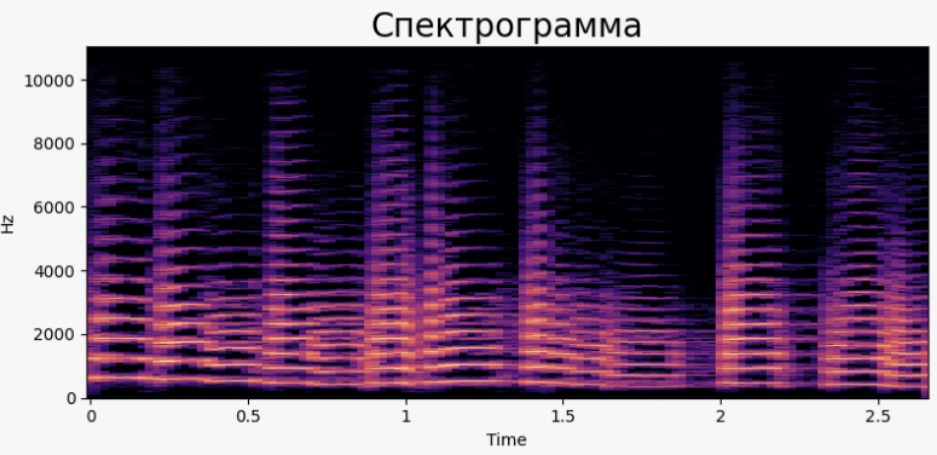

Интересно, что эта задача сводится к OLS (как?), поэтому оптимизация по сути такая же, как в обычной линейной регрессии.


Coefficients (reg): 
 -647.3466141356599 153.0336939672656
Coefficients (reg positive coef): 
 0.0 153.36255924170615
Mean squared error (reg): 4538.340456055545
Mean squared error (reg positive coef): 5568.964624559196


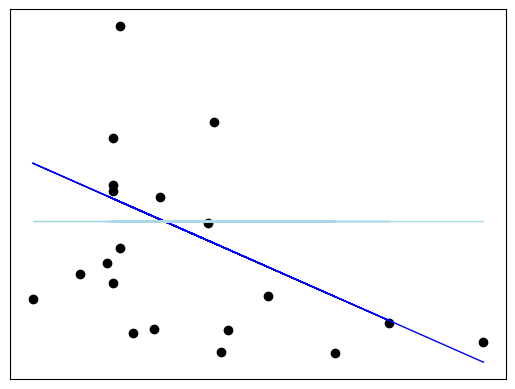

In [ ]:
# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

# Create linear regression object
regr = LinearRegression()
regr_nnls = LinearRegression(positive=True)

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)
regr_nnls.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)
diabetes_y_pred_nnls = regr_nnls.predict(diabetes_X_test)

# The coefficients
print("Coefficients (reg): \n", regr.coef_[0], regr.intercept_)
print("Coefficients (reg positive coef): \n", regr_nnls.coef_[0], regr_nnls.intercept_)

# The mean squared error
print(
    f"Mean squared error (reg): {mean_squared_error(diabetes_y_test, diabetes_y_pred)}"
)
print(
    f"Mean squared error (reg positive coef): {mean_squared_error(diabetes_y_test, diabetes_y_pred_nnls)}"
)

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test, color="black")
plt.plot(diabetes_X_test, diabetes_y_pred, color="blue", linewidth=1)
plt.plot(diabetes_X_test, diabetes_y_pred_nnls, color="lightblue", linewidth=1)
plt.xticks(())
plt.yticks(())
plt.show()

Какая у такой модели вероятностная интерпретация?

Как вы думаете, как такое обучать?

Вероятностная интерпретация такая же как у обычно линейное регресси но с wi>=0 поэтому ищем максимум правдоподобия с ограничением wi>=0
Можно попробоавать градиентный спускс с проекцией

### Orthogonal Mathcing Pursuit

![](https://upload.wikimedia.org/wikipedia/commons/3/38/Orthogonal_Matching_Pursuit.gif)

В обработке сигналов стандартная ситуация, когда число фичей сравнимо с числом точек данных, причем многие фичи сильно скореллированы.
Условно, мы хотим восстановить какой-то сигнал по данным. Для этого возьмем огромное количество базисных функций (например, [wavelet](https://en.wikipedia.org/wiki/Wavelet)'ов или любое другое семейство [ортогональных функций](https://ru.wikipedia.org/wiki/%D0%A0%D1%8F%D0%B4_%D0%A4%D1%83%D1%80%D1%8C%D0%B5#%D0%A2%D1%80%D0%B8%D0%B3%D0%BE%D0%BD%D0%BE%D0%BC%D0%B5%D1%82%D1%80%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9_%D1%80%D1%8F%D0%B4_%D0%A4%D1%83%D1%80%D1%8C%D0%B5), и вычислим в каждой точке из данных.

Алгоритм: найти фичу, которая сильнее всего коррелирует с таргетом, добавить в список разрешенных фичей, обучить OLS, вычесть из таргета предсказания нашей модели, повторить.

In [ ]:
n_components, n_features = 512, 100
n_nonzero_coefs = 17

# generate the data
y, X, w = make_sparse_coded_signal(
    n_samples=1,
    n_components=n_components,
    n_features=n_features,
    n_nonzero_coefs=n_nonzero_coefs,
    random_state=0,
)
X = X.T
(idx,) = w.nonzero()
X.shape, y.shape, w.shape

((100, 512), (100,), (512,))

0.0


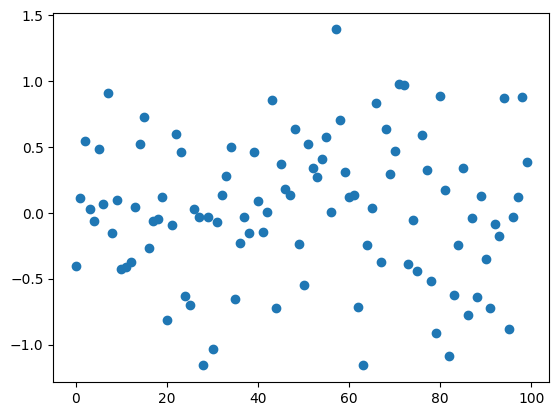

In [ ]:
print(((X @ w - y) ** 2).sum())
plt.scatter(np.arange(len(y)), y);

In [ ]:
A = 0.05

# distort the clean signal
y_noisy = y + A * np.random.randn(len(y))

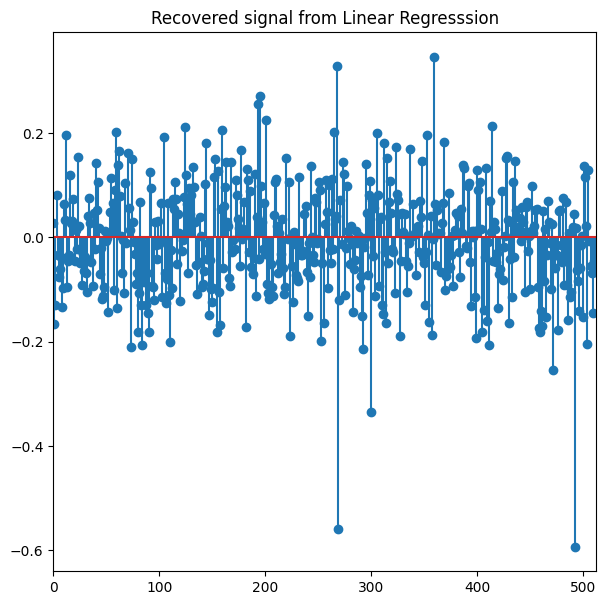

In [ ]:
# plot the noise-free reconstruction
ols = LinearRegression()
ols.fit(X, y)
coef = ols.coef_
(idx_r,) = coef.nonzero()
plt.figure(figsize=(7, 7))
# plt.subplot(4, 1, 2)
plt.xlim(0, 512)
plt.title("Recovered signal from Linear Regresssion")
plt.stem(idx_r, coef[idx_r]);

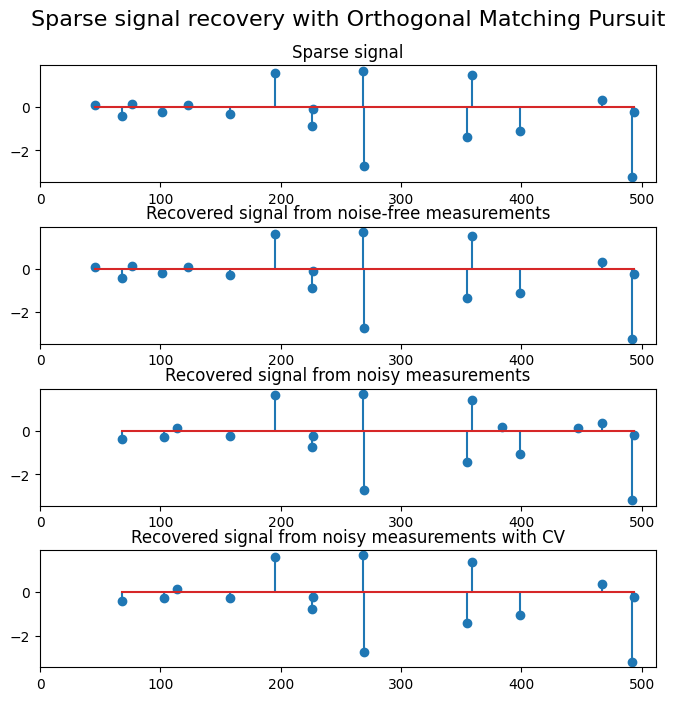

In [ ]:
# plot the sparse signal
plt.figure(figsize=(7, 7))
plt.subplot(4, 1, 1)
plt.xlim(0, 512)
plt.title("Sparse signal")
plt.stem(idx, w[idx])

# plot the noise-free reconstruction
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)
omp.fit(X, y)
coef = omp.coef_
(idx_r,) = coef.nonzero()
plt.subplot(4, 1, 2)
plt.xlim(0, 512)
plt.title("Recovered signal from noise-free measurements")
plt.stem(idx_r, coef[idx_r])

# plot the noisy reconstruction
omp.fit(X, y_noisy)
coef = omp.coef_
(idx_r,) = coef.nonzero()
plt.subplot(4, 1, 3)
plt.xlim(0, 512)
plt.title("Recovered signal from noisy measurements")
plt.stem(idx_r, coef[idx_r])

# plot the noisy reconstruction with number of non-zeros set by CV
omp_cv = OrthogonalMatchingPursuitCV()
omp_cv.fit(X, y_noisy)
coef = omp_cv.coef_
(idx_r,) = coef.nonzero()
plt.subplot(4, 1, 4)
plt.xlim(0, 512)
plt.title("Recovered signal from noisy measurements with CV")
plt.stem(idx_r, coef[idx_r])

plt.subplots_adjust(0.06, 0.04, 0.94, 0.90, 0.20, 0.38)
plt.suptitle("Sparse signal recovery with Orthogonal Matching Pursuit", fontsize=16)
plt.show()

# Robust Regression
  

OLS чувствительна к выбросам, поэтому...

* Random Sample Consensus Regression (RANSAC): обучить модель на случайном подмножестве, поделить точки на inliers и outliers, обучить на inliers, повторить. Ответ -- множество, максимизирующее число inlierэов. **Что может пойти не так при слишком маленьком пороге на inlierов?**
* Huber: use a loss which grows quadratically with distance, and then switches to linear $$
L_\delta (r) = \begin{cases}
 \frac{1}{2}{r^2}                   & \text{for } |r| \le \delta, \\
 \delta \cdot \left(|r| - \frac{1}{2}\delta\right), & \text{otherwise.}
\end{cases}
$$
![](https://upload.wikimedia.org/wikipedia/commons/c/cc/Huber_loss.svg)
* TheilSen: обучить `n_subsamples` раз OLS на подномжествах, усреднить веса.

----

* RANSAC is good for strong outliers in the y direction

* TheilSen is good for small outliers, both in direction X and y, but has a break point above which it performs worse than OLS.

* The scores of HuberRegressor may not be compared directly to both TheilSen and RANSAC because it does not attempt to completely filter the outliers but lessen their effect.


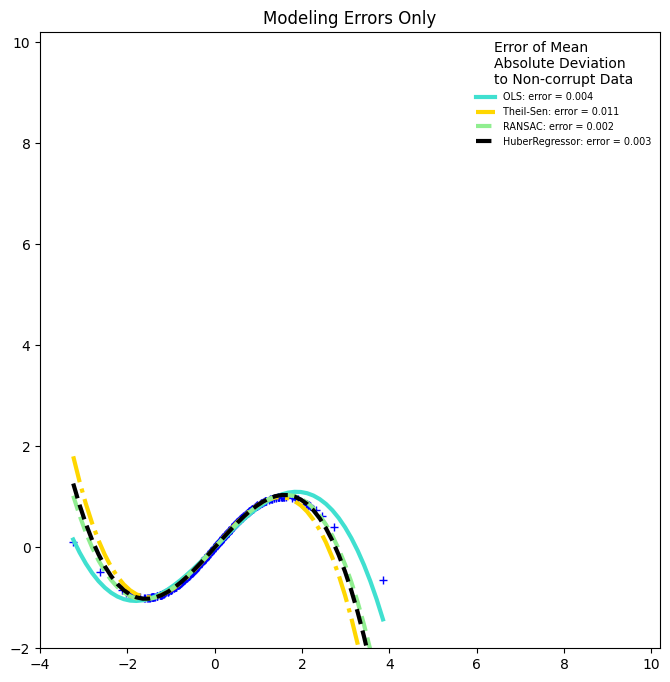

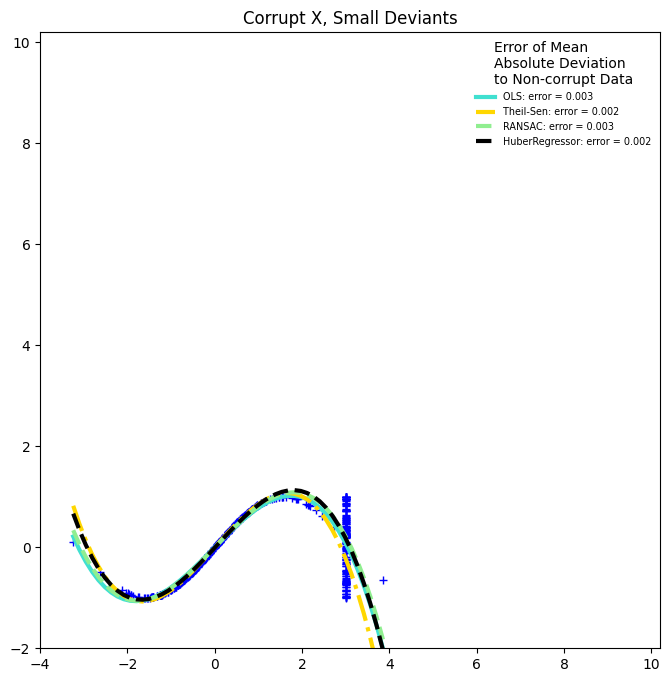

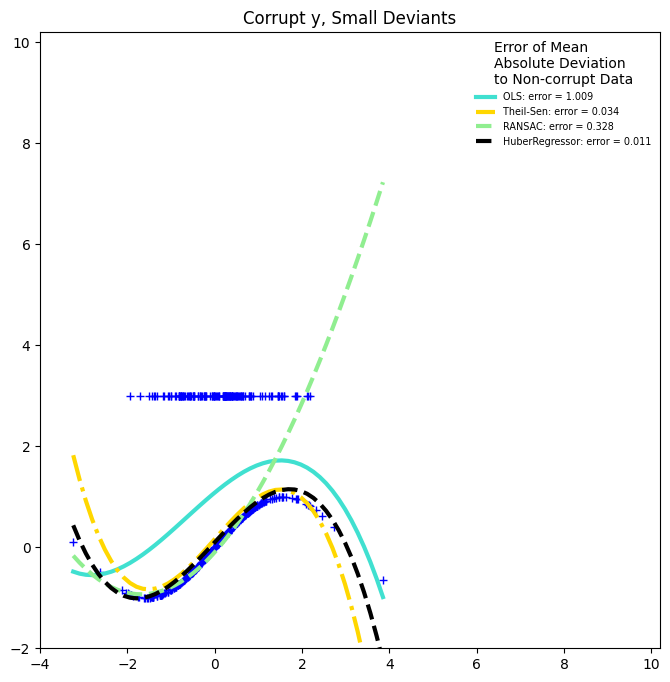

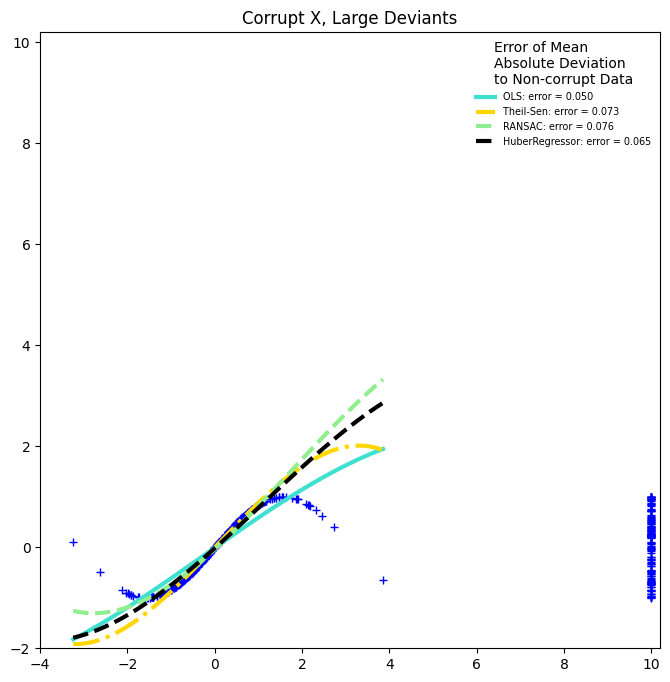

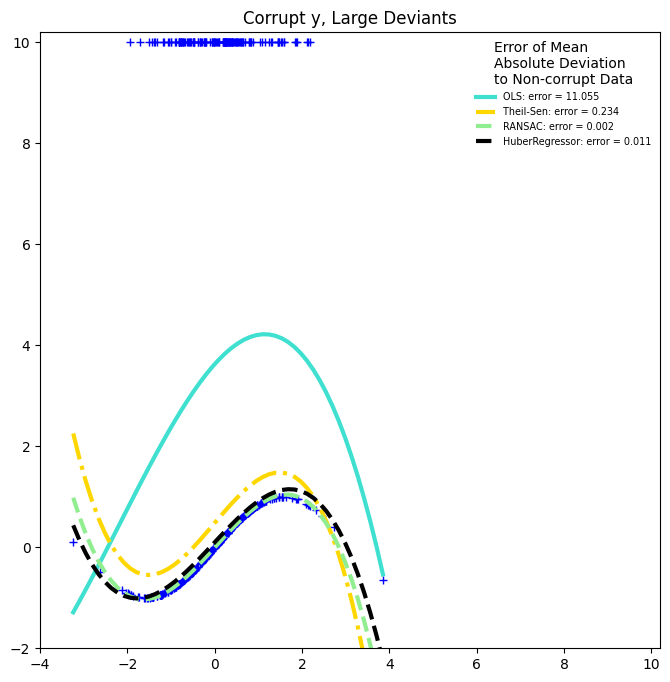

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.linear_model import (
    HuberRegressor,
    LinearRegression,
    RANSACRegressor,
    TheilSenRegressor,
)
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

np.random.seed(42)

X = np.random.normal(size=400)
y = np.sin(X)
# Make sure that it X is 2D
X = X[:, np.newaxis]

X_test = np.random.normal(size=200)
y_test = np.sin(X_test)
X_test = X_test[:, np.newaxis]

y_errors = y.copy()
y_errors[::3] = 3

X_errors = X.copy()
X_errors[::3] = 3

y_errors_large = y.copy()
y_errors_large[::3] = 10

X_errors_large = X.copy()
X_errors_large[::3] = 10

estimators = [
    ("OLS", LinearRegression()),
    ("Theil-Sen", TheilSenRegressor(random_state=42)),
    ("RANSAC", RANSACRegressor(random_state=42)),
    ("HuberRegressor", HuberRegressor()),
]
colors = {
    "OLS": "turquoise",
    "Theil-Sen": "gold",
    "RANSAC": "lightgreen",
    "HuberRegressor": "black",
}
linestyle = {"OLS": "-", "Theil-Sen": "-.", "RANSAC": "--", "HuberRegressor": "--"}
lw = 3

x_plot = np.linspace(X.min(), X.max())
for title, this_X, this_y in [
    ("Modeling Errors Only", X, y),
    ("Corrupt X, Small Deviants", X_errors, y),
    ("Corrupt y, Small Deviants", X, y_errors),
    ("Corrupt X, Large Deviants", X_errors_large, y),
    ("Corrupt y, Large Deviants", X, y_errors_large),
]:
    plt.figure(figsize=(8, 8))
    plt.plot(this_X[:, 0], this_y, "b+")

    for name, estimator in estimators:
        model = make_pipeline(PolynomialFeatures(3), estimator)
        model.fit(this_X, this_y)
        mse = mean_squared_error(model.predict(X_test), y_test)
        y_plot = model.predict(x_plot[:, np.newaxis])
        plt.plot(
            x_plot,
            y_plot,
            color=colors[name],
            linestyle=linestyle[name],
            linewidth=lw,
            label="%s: error = %.3f" % (name, mse),
        )

    legend_title = "Error of Mean\nAbsolute Deviation\nto Non-corrupt Data"
    legend = plt.legend(
        loc="upper right", frameon=False, title=legend_title, prop=dict(size="x-small")
    )
    plt.xlim(-4, 10.2)
    plt.ylim(-2, 10.2)
    plt.title(title)
plt.show()

# Orthogonal Distance Regression

Помните задачу со звездочкой про восстановление эллипса? Там были не совсем честные точки, шум семплировался только вдоль оси y. С помощью этой модели, можно будет восстановить эллипс по данным с честным шумом во всех направлениях.

![](https://media.geeksforgeeks.org/wp-content/uploads/20211219223720/19121.png)

OLS - предполагает что фичи такие, какие они есть, а таргеты - измерены с нормально распределенной ошибкой. Но на самом то деле, мы фичи тоже измерям с какой-то ошибкой, почему бы не попробовать поискать прямую, честные расстояния до имеющихся точек?

Какое вероятностное предположение будет соответсвовать такой модели?

Предполагается, что каждая наблюдаемая точка
(𝑥𝑖, 𝑦𝑖) отклоняется от истинной прямой шумом в x и y. Т. е. ошибки есть по обеим координатам, минимизируется сумма ортогональных (перпендикулярных) расстояний.

# Задача со звездочкой 11: NNLS (2 балла)
Напишите свою Non-Negative-Least-Squares на numpy **(scipy.optimize нельзя)**.

Подробно прокомментируйте, почему ваш алгоритм работает.





In [ ]:
"""
решить: argmin_x = ||Ax - b||_2
ограничение:  x>=0
где
A - (m, n) матрица признаков
b - (m,) вектор целевых значений

1) Буду использовать scipy.optimize (Lawson-Hanson (Active Set Method)) чтобы в конце сравнить результаты
2) Попробую реализовать с помощью Projected Gradient Descent
Коротко об алгоритме PGD:
1. Считаем градиент(куда нам надо менять веса x, чтобы ошибка падала)
2. Сдвигаем x против градиента
3. Если какой-то вес стал отрицательным принудительно ставим его в 0
"""

import numpy as np


def nnls_solver(A, b, max_iter=5000, tol=1e-6):
    m, n = A.shape
    x = np.zeros(n)
    AtA = A.T @ A
    Atb = A.T @ b
    L = np.linalg.norm(AtA, 2)

    if L == 0:
        return x

    lr = 1.0 / L

    for i in range(max_iter):
        grad = AtA @ x - Atb
        x_new = x - lr * grad
        x_new = np.maximum(x_new, 0)

        if np.linalg.norm(x_new - x) < tol:
            x = x_new
            break

        x = x_new

    return x


if __name__ == "__main__":
    A_test = np.array([[1.0, 1.0], [1.0, 2.0], [1.0, 3.0]])
    b_test = np.array([1.0, 0.5, 0.0])
    my_w = nnls_solver(A_test, b_test)
    print("Мои веса:", np.round(my_w, 4))

    from scipy.optimize import nnls

    scipy_w, _ = nnls(A_test, b_test)
    print("Scipy веса:", np.round(scipy_w, 4))

Мои веса: [0.5 0. ]
Scipy веса: [0.5 0. ]


# Задача со звездочкой 12: ODR (4 балла)
Откройте [ODRPACK User Guide](https://docs.scipy.org/doc/external/odrpack_guide.pdf) (осторожно: FORTRAN-77), и разберитесь что происходит в этом примере, поищите более современные данные и воспроизведите.



Оценённые параметры (scipy.odr): [ 1.26465481e+03 -5.40184107e+01 -8.78497227e-02]
Стандартные ошибки: [1.03492715 1.5839995  0.00633223]
res_var: 2.382833517980149
sum_square: 21.445501661821346
Параметры из ODRPACK: [ 1.2647e+03 -5.4000e+01 -8.7800e-02]


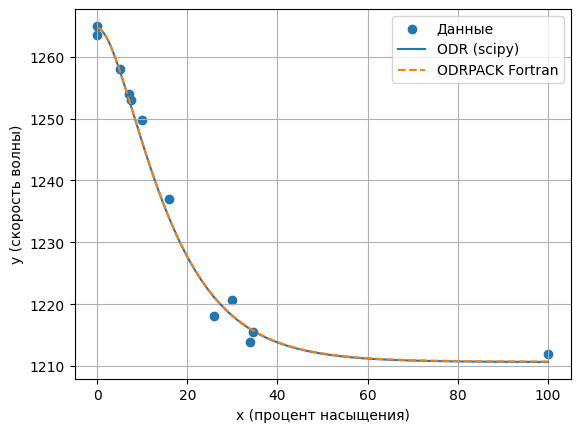

In [ ]:
import numpy as np
from scipy import odr
import matplotlib.pyplot as plt

# Данные из примера ODRPACK (data1)
x = np.array([0.0,   0.0,   5.0,   7.0,   7.5,  10.0,
              16.0, 26.0,  30.0,  34.0,  34.5, 100.0])
y = np.array([1265.0, 1263.6, 1258.0, 1254.0, 1253.0, 1249.8,
              1237.0, 1218.0, 1220.6, 1213.8, 1215.5, 1212.0])

# Модель из гайда: y = beta1 + beta2 * (exp(beta3 * x) - 1)^2
def fuller_model(beta, x):
    return beta[0] + beta[1] * (np.exp(beta[2] * x) - 1.0) ** 2

# Стартовые значения, как в ODRPACK
beta0 = np.array([1500.0, -50.0, -0.1])

# Ошибки в x и y: одинаковые, но для x=0 и x=100 делаем почти "идеальные" измерения
sx = np.ones_like(x)
sy = np.ones_like(y)
sx[(x == 0.0) | (x == 100.0)] = 1e-6  # почти фиксированные точки по x

data = odr.RealData(x, y, sx=sx, sy=sy)
model = odr.Model(fuller_model)

od = odr.ODR(data, model, beta0=beta0)
out = od.run()

print("Оценённые параметры (scipy.odr):", out.beta)
print("Стандартные ошибки:", out.sd_beta)
print("res_var:", out.res_var)
print("sum_square:", out.sum_square)

# Для сравнения — параметры из отчёта ODRPACK
beta_fortran = np.array([1264.7, -54.0, -0.0878])
print("Параметры из ODRPACK:", beta_fortran)

# График: данные, фит scipy.odr и кривая с fortran-параметрами
x_f = np.linspace(x.min(), x.max(), 500)
y_fit = fuller_model(out.beta, x_f)
y_fortran = fuller_model(beta_fortran, x_f)

plt.figure()
plt.scatter(x, y, label="Данные")
plt.plot(x_f, y_fit, label="ODR (scipy)")
plt.plot(x_f, y_fortran, linestyle="--", label="ODRPACK Fortran")
plt.xlabel("x (процент насыщения)")
plt.ylabel("y (скорость волны)")
plt.legend()
plt.grid(True)
plt.show()

Я решил попробовать поработать с [датасетом](https://www.kaggle.com/datasets/imranulhaquenoor/volve-dataset-well-f-9-a/data?select=Norway-NA-15_47_9-F-9+A+time.csv)

In [ ]:
!pip -q install kaggle

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d imranulhaquenoor/volve-dataset-well-f-9-a
!unzip -o volve-dataset-well-f-9-a.zip
!ls -lh
!ls -la

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/imranulhaquenoor/volve-dataset-well-f-9-a
License(s): CC-BY-NC-SA-4.0
volve-dataset-well-f-9-a.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  volve-dataset-well-f-9-a.zip
  inflating: Norway-NA-15_47_9-F-9 A depth.csv  
  inflating: Norway-NA-15_47_9-F-9 A time.csv  
total 452M
-rw-r--r-- 1 root root 5.4M Sep  7  2022 'Norway-NA-15_47_9-F-9 A depth.csv'
-rw-r--r-- 1 root root 409M Sep  7  2022 'Norway-NA-15_47_9-F-9 A time.csv'
drwxr-xr-x 1 root root 4.0K Dec 11 14:34  sample_data
-rw-r--r-- 1 root root  39M Sep  7  2022  volve-dataset-well-f-9-a.zip
total 462840
drwxr-xr-x 1 root root      4096 Dec 16 14:47  .
drwxr-xr-x 1 root root      4096 Dec 16 14:32  ..
drwxr-xr-x 4 root root      4096 Dec 11 14:34  .config
-rw-r--r-- 1 root root   5596360 Sep  7  2022 'Norway-NA-15_47_9-F-9 A depth.csv'
-rw-r--r-- 1 root root 427910797 Sep  7  2022 'Norway-NA-15_47_9-

In [ ]:
import pandas as pd

Norway_NA_time_df = pd.read_csv("Norway-NA-15_47_9-F-9 A time.csv")
Norway_NA_depth_df = pd.read_csv("Norway-NA-15_47_9-F-9 A depth.csv")

/tmp/ipython-input-3954099454.py:3: DtypeWarning: Columns (119,146,226,229,232,236) have mixed types. Specify dtype option on import or set low_memory=False.
  Norway_NA_time_df = pd.read_csv("Norway-NA-15_47_9-F-9 A time.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419747 entries, 0 to 419746
Columns: 239 entries, Unnamed: 0.1 to DateTime parsed
dtypes: float64(228), int64(1), object(10)
memory usage: 765.4+ MB


In [ ]:
Norway_NA_time_df.head()

,Unnamed: 0.1,Unnamed: 0,Time s,Pump 2 Stroke Rate 1/min,MudPit Volume Average 5 m3,TOFB s,Block Velocity m/s,SPP/SPM2 unitless,MAG_DEC dega,Mud Density Out g/cm3,...,WBSCALIPERMNEMONIC unitless,WBSTRAJECTORYMNEMONIC unitless,WBSLITHOLOGY4 unitless,WBSBITDEPMNEMONIC unitless,WBSLITHOLOGY3 unitless,WBSLITHOLOGY2 unitless,WBSTUBULARMNEMONIC unitless,WBSHOLEDEPMNEMONIC unitless,WBSWBGEOMETRYMNEMONIC unitless,DateTime parsed
0,0,0.0,2009-06-27T16:50:29.000Z,NaN,61.529999,NaN,NaN,NaN,NaN,0.79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-06-27 16:50:29+00:00
1,1,1.0,2009-06-27T16:50:33.000Z,NaN,61.400002,NaN,NaN,NaN,NaN,0.79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-06-27 16:50:33+00:00
2,2,2.0,2009-06-27T16:50:38.000Z,NaN,61.290001,NaN,NaN,NaN,NaN,0.79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-06-27 16:50:38+00:00
3,3,3.0,2009-06-27T16:50:42.000Z,NaN,61.209999,NaN,NaN,NaN,NaN,0.79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-06-27 16:50:42+00:00
4,4,4.0,2009-06-27T16:50:47.000Z,NaN,61.220001,NaN,NaN,NaN,NaN,0.79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-06-27 16:50:47+00:00


In [ ]:
cols = ["Gas (avg) %", "MWD Gamma Ray (API BH corrected) gAPI"]

Norway_NA_depth_df = Norway_NA_depth_df[cols].copy()

Norway_NA_depth_df[cols] = Norway_NA_depth_df[cols].apply(pd.to_numeric, errors="coerce")
Norway_NA_depth_df = Norway_NA_depth_df.dropna()

Norway_NA_depth_df.head()


,Gas (avg) %,MWD Gamma Ray (API BH corrected) gAPI
2848,0.2138,140.10
4227,0.2807,155.49
6169,0.2665,146.26
7948,0.1804,164.73


In [ ]:
x = Norway_NA_depth_df["Gas (avg) %"].to_numpy()
y = Norway_NA_depth_df["MWD Gamma Ray (API BH corrected) gAPI"].to_numpy()

In [ ]:
x

array([0.2138, 0.2807, 0.2665, 0.1804])

In [ ]:
y

array([140.1 , 155.49, 146.26, 164.73])

In [ ]:
def quad_model(beta, x):
    return beta[0] + beta[1]*x + beta[2]*x**2

In [ ]:
b2, b1, b0 = np.polyfit(x, y, 2)
beta0 = np.array([b0, b1, b2])


In [ ]:
sx = 0.05 * np.maximum(np.abs(x), 1e-3)
sy = 0.02 * np.maximum(np.abs(y), 1e-3)


beta: [ 1.26487736e+03 -5.49945477e+01 -8.32301068e-02]
sd_beta: [1.27037511 1.7866389  0.00580746]
res_var: 0.007468693731899264


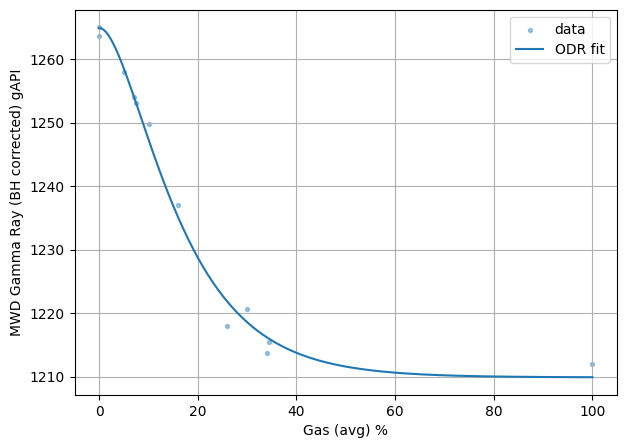

In [ ]:
import numpy as np
from scipy import odr
import matplotlib.pyplot as plt

data = odr.RealData(x, y, sx=sx, sy=sy)
model = odr.Model(fuller_model)

od = odr.ODR(data, model, beta0=beta0)
out = od.run()

print("beta:", out.beta)
print("sd_beta:", out.sd_beta)
print("res_var:", out.res_var)

# график
x_f = np.linspace(x.min(), x.max(), 300)
y_fit = fuller_model(out.beta, x_f)

plt.figure(figsize=(7,5))
plt.scatter(x, y, s=8, alpha=0.4, label="data")
plt.plot(x_f, y_fit, label="ODR fit")
plt.xlabel("Gas (avg) %")
plt.ylabel("MWD Gamma Ray (BH corrected) gAPI")
plt.grid(True)
plt.legend()
plt.show()